# Event inspection tools
Last modification: 2023.11.07. </br>
Update note: Clean up

# Initiation

In [1]:
import numpy as np
import matplotlib.pylab as plt
from faultoutputs_image import *
import setup_shortcut
import change_params
import myplots
from read_outputs import load_fault_probe_outputs
plt.rcParams['font.size'] = '15'

sc = setup_shortcut.setups()
mp = myplots.Figpref()
ch = change_params.variate()

prefix = 'perturb_stress/reference'
# prefix = 'perturb_stress/no_cp_reference'

# ----------
save_dir = '/export/dump/jyun/'+prefix
# outputs,dep,params = load_fault_probe_outputs(save_dir)

# ----------
y,Hs,a,b,a_b,tau0,sigma0,Dc,others = ch.load_parameter(prefix)

Fractal normal stress model ver.6
Fractal a-b model ver.2
Fractal Dc model ver.2
Using file fractal_snpre_06
Using file fractal_ab_02
Using file fractal_Dc_02


In [2]:
from read_outputs import load_short_fault_probe_outputs
outputs,dep,params = load_short_fault_probe_outputs(save_dir,0)

Load saved data: /export/dump/jyun/perturb_stress/reference/short_outputs_0
Load saved data: /export/dump/jyun/perturb_stress/reference/outputs_depthinfo
Load saved data: /export/dump/jyun/perturb_stress/reference/const_params.npy


## Load variables

In [3]:
from cumslip_compute import *
import os

image = 'sliprate'
# image = 'shearT'
print('Image %s figure'%(image))

if image == 'sliprate':
    vmin,vmax = 1e-12,1e1
elif image == 'shearT':
    vmin,vmax = -5,5
else:
    vmin,vamx = None,None

if 'v6_ab2_Dc2' in prefix:
    Vths = 1e-1
    intv = 0.15
elif 'perturb_stress' in prefix:
    Vths = 2e-1
    intv = 0.15
else:
    Vths = 1e-2
    intv = 0.
Vlb = 0
dt_interm = 0
cuttime = 0
rths = 10
dt_creep = 2*ch.yr2sec
dt_coseismic = 0.5

if os.path.exists('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10)):
    print('Load saved file')
    cumslip_outputs = np.load('%s/cumslip_outputs_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10),allow_pickle=True)
else:
    print('Compute event details')
    cumslip_outputs = compute_cumslip(outputs,dep,cuttime,Vlb,Vths,dt_creep,dt_coseismic,dt_interm,intv)
tstart,tend,evdep = cumslip_outputs[0][0],cumslip_outputs[0][1],cumslip_outputs[1][1]
rupture_length,av_slip,system_wide,partial_rupture,event_cluster,lead_fs,major_pr,minor_pr = analyze_events(cumslip_outputs,rths)
if len(major_pr) > 0: major_pr = event_cluster[major_pr][:,1]
if len(minor_pr) > 0: minor_pr = event_cluster[minor_pr][:,1]
if os.path.exists('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10)):
    print('Load saved file')
    spin_up_idx = np.load('%s/spin_up_idx_Vths_%1.0e_srvar_%03d_rths_%d_tcreep_%d_tseis_%02d.npy'%(save_dir,Vths,intv*100,rths,dt_creep/ch.yr2sec,dt_coseismic*10))
else:
    print('Compute spin-up index')
    spin_up_idx = compute_spinup(outputs,dep,cuttime,cumslip_outputs,['yrs',200],rths)[-1]
    # spup_cumslip_outputs = compute_spinup(outputs,dep,cuttime,cumslip_outputs,['yrs',200],rths)
    # spin_up_idx = spup_cumslip_outputs[-1]

print('Total number of events: %d / Spin-up index: %d'%(len(tstart),spin_up_idx))
print('System-size indexes:',system_wide)

Image sliprate figure
Load saved file
Load saved file
Total number of events: 575 / Spin-up index: 30
System-size indexes: [  7  13  22  30  39  51  58  62  68  74  81  88  97 105 113 120 124 131
 139 147 151 157 167 175 187 194 206 213 225 232 244 251 263 270 282 289
 301 308 320 327 339 346 358 365 377 384 396 403 415 422 434 441 453 460
 472 479 491 498 510 517 529 536 548 555 567 574]


In [ ]:
time = np.array(outputs[0,:,0])
state = np.array([outputs[i][:,1] for i in np.argsort(abs(dep))])
cumslip = np.array([outputs[i][:,2] for i in np.argsort(abs(dep))])
shearT = np.array([outputs[i][:,3] for i in np.argsort(abs(dep))])
normalT = np.array([outputs[i][:,5] for i in np.argsort(abs(dep))])
sr = abs(np.array([outputs[i][:,4] for i in np.argsort(abs(dep))]))
z = np.sort(abs(dep))

In [93]:
target_eventid = 20
model_n = 'vert_slow'
mu = 0.4
receivef_strike = 340
idx = system_wide[system_wide>=spin_up_idx][target_eventid]
from stress_model_tools import fixed_model

# pdyn,static = fixed_model('perturb_stress/seissol_outputs',model_n,receivef_strike,[evdep[idx]],[1],mu,True)
pdyn,static = fixed_model('perturb_stress/seissol_outputs',model_n,receivef_strike,z[2:-1],np.ones(len(z[2:-1])),mu,True)
# trange = np.arange(np.argmin(abs(tstart[idx]-58320-time))-1,np.argmin(abs(tstart[idx]-time))+1)
trange = np.arange(np.argmin(abs(tstart[idx]-58320-time))-1,np.argmin(abs(tend[idx]-time)))

# print(pdyn,static)

# accum_stress = [abs(shearT[di,trange]).max() - abs(shearT[di,trange]).min() for di in range(len(z))]
accum_stress = np.array([abs(shearT[di,trange])[trange==np.argmin(abs(tstart[idx]-time))] - abs(shearT[di,trange])[0] for di in range(len(z))])
pert_percentage_dynamic = np.array([abs(pdyn[i]/accum_stress[2:-1][i])*100 for i in range(len(z[2:-1]))])
pert_percentage_static = np.array([abs(static[i]/accum_stress[2:-1][i])*100 for i in range(len(z[2:-1]))])

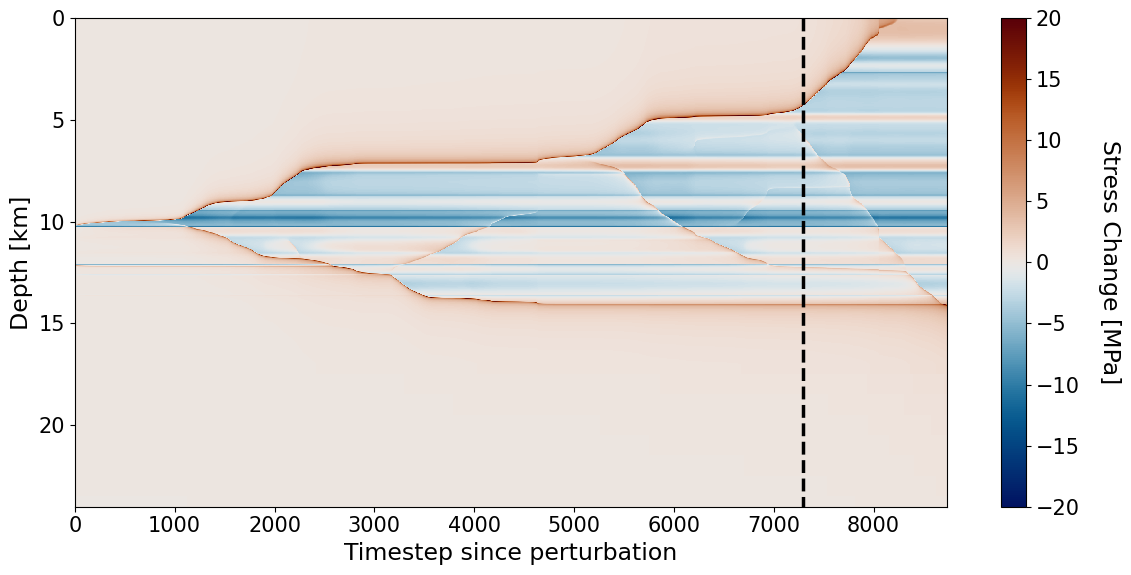

In [96]:
import cmcrameri.cm as cram
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(12,6))

X,Y = np.meshgrid(np.arange(len(trange)),z)
# cb=plt.pcolor(X,Y,abs(shearT[:,trange]),vmin=29,vmax=50)
# plt.colorbar(cb).set_label('Stress [MPa]',fontsize=17,rotation=270,labelpad=30)
cb=plt.pcolor(X,Y,[-shearT[di,trange]+shearT[di,trange[0]] for di in range(len(z))],vmin=-20,vmax=20,cmap=cram.vik)
plt.colorbar(cb).set_label('Stress Change [MPa]',fontsize=17,rotation=270,labelpad=30)
plt.vlines(x=np.argmin(abs(tstart[idx]-time))-trange[0],ymin=0,ymax=24,color='k',linestyle='--',lw=2.5)
plt.xlabel('Timestep since perturbation',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.ylim(0,24)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

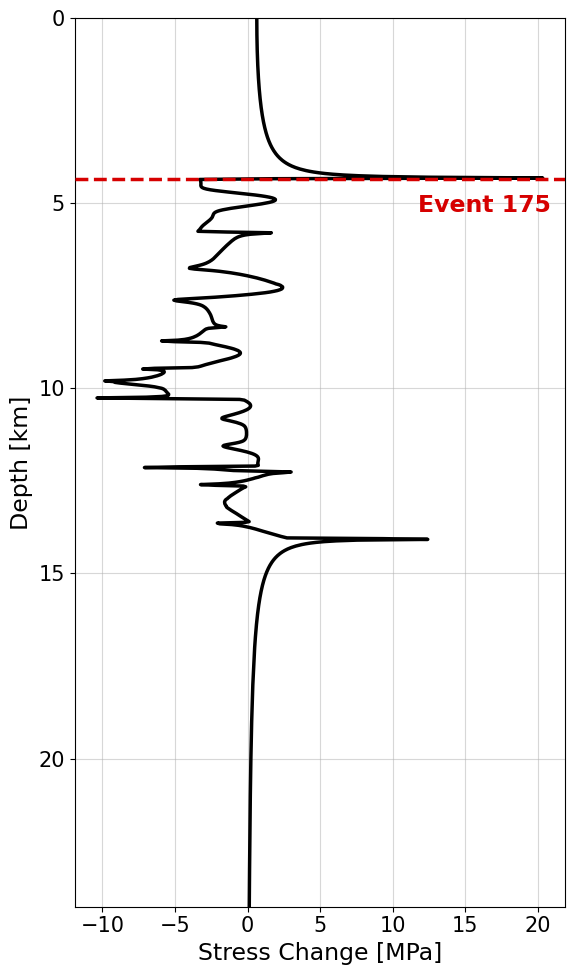

In [60]:
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(6,10))

plt.plot(accum_stress,z,'k',lw=2.5,zorder=3)
xl = ax.get_xlim()
plt.hlines(y=evdep[idx],xmin=xl[0],xmax=xl[1],color=mp.myburgundy,linestyle='--',lw=2.5,label='Hypocenter',zorder=3)
plt.text(xl[1]-(xl[1]-xl[0])*0.3,evdep[idx]+0.4,'Event %d'%(idx),ha='left',va='top',color=mp.myburgundy,fontsize=17,fontweight='bold')
plt.xlabel('Stress Change [MPa]',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.xlim(xl)
plt.ylim(0,24)
plt.grid(True,alpha=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [110]:
zloc = np.argmin(abs(z-evdep[idx]))
np.mean(accum_stress[zloc-1:zloc+1])

11.087300647267176

In [112]:
accum_stress[zloc-1:zloc+1]

array([[20.34972171],
       [ 1.82487958]])

Average accumulated stress near hypocenter: 11.09 MPa
Average peak. dynamic dCFS near hypocenter: 0.57 MPa (5.21%)
Average static dCFS near hypocenter: 0.09 MPa (0.85%)


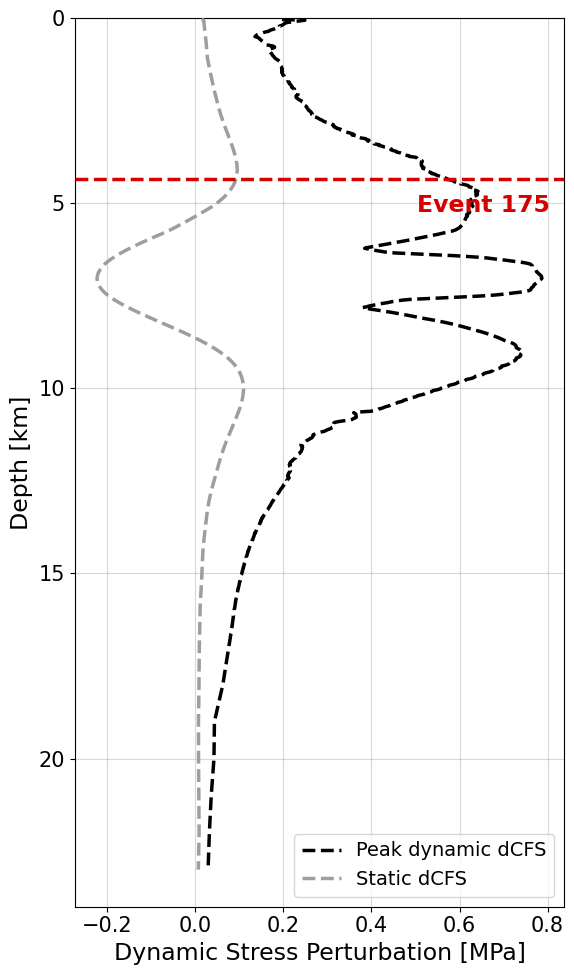

In [120]:
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(6,10))

plt.plot(pdyn,z[2:-1],c='k',lw=2.5,zorder=3,linestyle='--',label='Peak dynamic dCFS')
plt.plot(static,z[2:-1],c='0.62',lw=2.5,zorder=3,linestyle='--',label='Static dCFS')
# zloc = np.argmin(abs(z-evdep[idx]))
# print('Average accumulated stress near hypocenter: %1.2f MPa'%(np.mean(accum_stress[zloc-1:zloc+1])))
# zloc = np.argmin(abs(z[2:-1]-evdep[idx]))
# print('Average peak. dynamic dCFS near hypocenter: %1.2f MPa (%1.2f%%)'%(np.mean(pdyn[zloc-1:zloc+1]),np.mean(pdyn[zloc-1:zloc+1])/np.mean(accum_stress[zloc-1:zloc+1])*100))
# print('Average static dCFS near hypocenter: %1.2f MPa (%1.2f%%)'%(np.mean(static[zloc-1:zloc+1]),np.mean(static[zloc-1:zloc+1])/np.mean(accum_stress[zloc-1:zloc+1])*100))
zloc1 = np.argmax(accum_stress)
print('Average accumulated stress near hypocenter: %1.2f MPa'%(accum_stress[zloc1]))
zloc = np.argmin(abs(z[2:-1]-z[zloc]))
print('Average peak. dynamic dCFS near hypocenter: %1.2f MPa (%1.2f%%)'%(pdyn[zloc],pdyn[zloc])/np.mean(accum_stress[zloc1]*100))
print('Average static dCFS near hypocenter: %1.2f MPa (%1.2f%%)'%(np.mean(static[zloc-1:zloc+1]),np.mean(static[zloc-1:zloc+1])/np.mean(accum_stress[zloc-1:zloc+1])*100))

# plt.plot(pdyn,z[2:-1],c=mp.mypink,lw=2.5,zorder=3,linestyle='--',label='Peak dynamic dCFS')
# plt.plot(static,z[2:-1],c=mp.myblue,lw=2.5,zorder=3,linestyle='--',label='Static dCFS')
# plt.plot(accum_stress,z,'k',lw=2.5,zorder=3)
# plt.plot(pert_percentage_dynamic,z[2:-1],c=mp.mypink,lw=2.5,zorder=3,label='Peak dynamic dCFS')
# plt.plot(pert_percentage_static,z[2:-1],c=mp.myblue,lw=2.5,zorder=3,linestyle='--',label='Static dCFS')
# plt.xlim(-5,100)
xl = ax.get_xlim()
plt.hlines(y=evdep[idx],xmin=xl[0],xmax=xl[1],color=mp.myburgundy,linestyle='--',lw=2.5,zorder=3)
plt.text(xl[1]-(xl[1]-xl[0])*0.3,evdep[idx]+0.4,'Event %d'%(idx),ha='left',va='top',color=mp.myburgundy,fontsize=17,fontweight='bold')
plt.legend(fontsize=14)
plt.xlabel('Dynamic Stress Perturbation [MPa]',fontsize=17)
# plt.xlabel('Percentage of the Perturbation',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
# plt.ylabel('Absolute Shear Stress [MPa]',fontsize=17)
plt.xlim(xl)
plt.ylim(0,24)
plt.grid(True,alpha=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [116]:
np.mean(pdyn[zloc-1:zloc+1])/np.mean(accum_stress[zloc-1:zloc+1])*100

5.212976728654613

# Various matrics

## Recurrence interval of system-size events

In [ ]:
rec_intv = np.diff(tstart[system_wide]/sc.yr2sec)
print(rec_intv)
print('Mean recurrence interval: %2.2f yrs'%(np.mean(rec_intv)))
print('Standard deviation of recurrence interval: %2.2f yrs'%(np.std(rec_intv)))

## Max. peak slip rate

In [ ]:
psr = np.max(sr,axis=0)
its_all = np.array([np.argmin(abs(outputs[0][:,0]-t)) for t in tstart])
ite_all = np.array([np.argmin(abs(outputs[0][:,0]-t)) for t in tend])
print('Max. peak slip rate: %2.4f m/s'%(np.array([max(psr[its_all[k]:ite_all[k]]) for k in range(len(tstart))]).max()))


## Moment vs. Duration

In [ ]:
from event_analyze import compute_M0
Mw = compute_M0(save_dir,rupture_length,av_slip,'approx2d',Mw=True)

In [ ]:
from event_analyze import compute_M0

save_on = 1
T = np.log10(tend-tstart)
M0 = np.log10(compute_M0(save_dir,rupture_length,av_slip,mode='approx2d',Mw=False))
yadj = 12

base_M = np.linspace(M0.min()-1,M0.max()+1,len(M0))

plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,10))
plt.scatter(M0[system_wide],T[system_wide],s=200,fc=mp.mydarkviolet,marker='*',ec='k',lw=1,zorder=3,label='System-size events')
plt.scatter(M0[partial_rupture],T[partial_rupture],s=65,fc=mp.mylightblue,marker='d',ec='k',lw=1,zorder=3,label='Partial rupture events')
plt.legend(fontsize=14,loc='upper left')
xl = ax.get_xlim()
plt.plot(base_M,base_M-14.5,c=mp.mypalepink,lw=15)
plt.plot(base_M,base_M/3-5.25,c='lemonchiffon',lw=15)
plt.text(17.9,0.9,'$M_0$~$T^3$',fontsize=17,rotation=30,va='bottom')
plt.text(17.9,3.5,'$M_0$~$T$',fontsize=17,rotation=60,va='top')
plt.grid(True,alpha=0.5)
plt.xlabel('$log_{10}$(Moment [Nm])',fontsize=17)
plt.ylabel('$log_{10}$(Event Duration [s])',fontsize=17)
plt.xlim(xl)
plt.ylim(-1,4)
plt.tight_layout()
if save_on: plt.savefig('%s/M0_vs_T.png'%(save_dir),dpi=300)
plt.show()

## Distribution of events

In [ ]:
# System-size events only
from event_analyze import compute_M0
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(18,6))

Mw = compute_M0(save_dir,rupture_length,av_slip,mode='approx2d',Mw=True)
rect=plt.Rectangle(xy=(-0.5,0),width=np.where(system_wide>=spin_up_idx)[0][0],height=Hs[0],facecolor='aliceblue',linewidth=2,edgecolor=mp.myblue)
ax.add_patch(rect)
cb = plt.scatter(np.arange(len(system_wide)),evdep[system_wide],150,ec='k',fc=mp.mydarkviolet,lw=1,marker='*',c = Mw[system_wide],cmap='magma_r',zorder=3)
plt.colorbar(cb).set_label('Mw',fontsize=15,rotation=270,labelpad=30)
xl = ax.get_xlim()
plt.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],linestyles='--',color='0.62',lw=1.5)
plt.hlines(y=Hs[-1],xmin=xl[0],xmax=xl[1],linestyles='--',color='0.62',lw=1.5)
plt.xlim(xl[0],xl[1])
plt.ylim(0,Hs[0])
ax.invert_yaxis()
plt.xticks(np.arange(len(system_wide)), minor=True)
plt.xlabel('System-size event index',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.grid(True,alpha=0.5,which='both')
plt.tight_layout()
plt.savefig('%s/depth_Mw_dist.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
# All events
from event_analyze import compute_M0
save_on = 0
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(28,6))

Mw = compute_M0(save_dir,rupture_length,av_slip,mode='approx2d',Mw=True)
# rect=plt.Rectangle(xy=(-0.5,0),width=np.where(system_wide>=spin_up_idx)[0][0],height=Hs[0],facecolor='aliceblue',linewidth=2,edgecolor=mp.myblue)
# ax.add_patch(rect)
cb = plt.scatter(partial_rupture,evdep[partial_rupture],50,ec='k',lw=1,marker='d',\
                 c=Mw[partial_rupture],cmap='magma_r',vmin=min(Mw),vmax=max(Mw),zorder=3)
cb = plt.scatter(system_wide,evdep[system_wide],150,ec='k',lw=1,marker='*',\
            c=Mw[system_wide],cmap='magma_r',vmin=min(Mw),vmax=max(Mw),zorder=3)
plt.colorbar(cb).set_label('Mw',fontsize=15,rotation=270,labelpad=30)
# xl = ax.get_xlim()
xl = [-5,len(evdep)-1+5]
plt.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],linestyles='--',color='0.62',lw=1.5)
plt.hlines(y=Hs[-1],xmin=xl[0],xmax=xl[1],linestyles='--',color='0.62',lw=1.5)
plt.xlim(xl[0],xl[1])
plt.ylim(0,Hs[0])
ax.invert_yaxis()
plt.xticks(np.arange(len(evdep)), minor=True)
plt.xlabel('Event index',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.grid(True,alpha=0.5,which='both')
plt.tight_layout()
if save_on: plt.savefig('%s/depth_Mw_dist_all.png'%(save_dir),dpi=300)
plt.show()

### Within certain time period

In [ ]:
from event_analyze import compute_M0
save_on = 0
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(28,7))

def find_group(ev):
    if ev < within_time_ec[0,0] or ev >= within_time_ec[-1,1]:
        col = 'w'
    else:
        kk = np.where(np.logical_and(within_time_ec[:,0]<=ev,within_time_ec[:,1]>=ev))[0][0]
        # if np.mod(kk,2) == 0: 
        if within_time_ec[kk,1] in within_time_sw: 
            col = mp.mydarkviolet
        else:
            col = mp.myyellow
    return col

within_time_pr = partial_rupture[np.where(np.logical_and(tstart[partial_rupture]>=outputs[0,:,0].min(),tstart[partial_rupture]<=outputs[0,:,0].max()))[0]]
within_time_sw = system_wide[np.where(np.logical_and(tstart[system_wide]>=outputs[0,:,0].min(),tstart[system_wide]<=outputs[0,:,0].max()))[0]]
within_time_ec = event_cluster[np.where(np.logical_and(event_cluster[:,0]>=min([within_time_sw.min(),within_time_pr.min()]),event_cluster[:,1]<=max([within_time_sw.max(),within_time_pr.max()])))[0],:]

Mw = compute_M0(save_dir,rupture_length,av_slip,mode='approx2d',Mw=True)
cb = plt.scatter(within_time_pr,evdep[within_time_pr],50,ec='k',lw=1,marker='d',\
                 fc=[find_group(pr) for pr in within_time_pr],zorder=3)
cb = plt.scatter(within_time_sw,evdep[within_time_sw],150,ec='k',lw=1,marker='*',\
            fc=[find_group(sw) for sw in within_time_sw],zorder=3)
xl = ax.get_xlim()
xl = [min([within_time_sw.min(),within_time_pr.min()])-2.5,max([within_time_sw.max(),within_time_pr.max()])+2.5]
plt.hlines(y=Hs[1],xmin=xl[0],xmax=xl[1],linestyles='--',color='0.62',lw=1.5)
plt.hlines(y=Hs[-1],xmin=xl[0],xmax=xl[1],linestyles='--',color='0.62',lw=1.5)
plt.xlim(xl[0],xl[1])
plt.ylim(0,Hs[0])
ax.invert_yaxis()
plt.xticks(np.arange(min([within_time_sw.min(),within_time_pr.min()]),max([within_time_sw.max(),within_time_pr.max()])+1), minor=True)
plt.xlabel('Event index',fontsize=17)
plt.ylabel('Depth [km]',fontsize=17)
plt.grid(True,alpha=0.5,which='both')
plt.tight_layout()
if save_on: plt.savefig('%s/depth_Mw_dist_short_1.png'%(save_dir),dpi=300)
plt.show()

## Before & after entering stable regime (perturb_stress/reference)

### Recurrence intervals

In [ ]:
# Print in text
ev_before = system_wide[system_wide<=175]
ev_after = system_wide[system_wide>175]
rec_intv_before = np.diff(tstart[ev_before]/sc.yr2sec)
rec_intv_after = np.diff(tstart[ev_after]/sc.yr2sec)
print('Mean recurrence interval: %2.2f yrs (before) | %2.2f yrs (after)'%(np.mean(rec_intv_before),np.mean(rec_intv_after)))
print('Standard deviation of recurrence interval: %2.2f yrs (before) | %2.2f yrs (after)'%(np.std(rec_intv_before),np.std(rec_intv_after)))

In [ ]:
# Show as histogram
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,6))
plt.hist(rec_intv_before,fc='0.62',label='Chaotic Regime',alpha=0.5)
plt.hist(rec_intv_before,ec='0.62',histtype='step',lw=2)
# plt.hist(nps_sw,ec=mp.myblue,bins=bns,histtype='step',lw=2,align='left')
plt.hist(rec_intv_after,fc=mp.mypink,label='Stable Regime',alpha=0.5)
plt.hist(rec_intv_after,ec=mp.mypink,histtype='step',lw=2)
plt.legend(fontsize=14)
plt.xlabel('Recurrence Interval [yrs]',fontsize=17)
plt.ylabel('Count',fontsize=17)
plt.show()

In [ ]:
# Plot as scatter
save_on = 0
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(15,7))

ii = np.arange(len(system_wide)-1)
plt.scatter(ii,np.diff(tstart[system_wide])/sc.yr2sec,150,ec='k',lw=1,marker='s',\
            fc=mp.mydarkviolet,zorder=3)
yl = ax.get_ylim()
transition = np.where(system_wide==175)[0][0]-0.5
# plt.vlines(x=np.where(system_wide==175)[0]-0.5,ymin=yl[0],ymax=yl[1],linestyles='--',color='0.62',lw=1.5)
rect=plt.Rectangle(xy=(0,yl[0]),width=transition-0,height=yl[1]-yl[0],\
                   facecolor='aliceblue',zorder=0,label='Chaotic Regime')
ax.add_patch(rect)
rect=plt.Rectangle(xy=(transition,yl[0]),width=ii.max()-transition,height=yl[1]-yl[0],\
                   facecolor='lemonchiffon',zorder=0,alpha=0.5,label='Stable Regime')
ax.add_patch(rect)
plt.ylim(yl[0],yl[1])
plt.xticks(ii, minor=True)
plt.legend(fontsize=17,loc = 'upper right')
plt.xlabel('Event difference index',fontsize=17)
plt.ylabel('Interval Between Events [yrs]',fontsize=17)
plt.grid(True,alpha=0.5,which='both')
plt.tight_layout()
if save_on: plt.savefig('%s/sys_ev_interval_short_1.png'%(save_dir),dpi=300)
plt.show()

### Peak value

In [ ]:
# Basic plot
from faultoutputs_vs_time import fout_time_max

within_time_pr = partial_rupture[np.where(np.logical_and(tstart[partial_rupture]>=outputs[0,:,0].min(),tstart[partial_rupture]<=outputs[0,:,0].max()))[0]]
within_time_sw = system_wide[np.where(np.logical_and(tstart[system_wide]>=outputs[0,:,0].min(),tstart[system_wide]<=outputs[0,:,0].max()))[0]]
within_time_ec = event_cluster[np.where(np.logical_and(event_cluster[:,0]>=min([within_time_sw.min(),within_time_pr.min()]),event_cluster[:,1]<=max([within_time_sw.max(),within_time_pr.max()])))[0],:]

plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(15,7))
# fout_time_max(save_dir,outputs,'state',plot_in_sec=False,prefix=save_dir.split('jyun/')[-1],dep=dep,save_on=False)
fout_time_max(save_dir,outputs,'slip',plot_in_sec=False,save_on=False)
xl = ax.get_xlim()
yl = ax.get_ylim()

rect=plt.Rectangle(xy=(xl[0],yl[0]),width=tstart[within_time_sw[5]]/sc.yr2sec-xl[0],height=yl[1]-yl[0],\
                   facecolor='aliceblue',zorder=0)
ax.add_patch(rect)
rect=plt.Rectangle(xy=(tstart[within_time_pr[37]]/sc.yr2sec,yl[0]),width=xl[1]-tstart[within_time_pr[37]]/sc.yr2sec,height=yl[1]-yl[0],\
                   facecolor='lemonchiffon',zorder=0,alpha=0.5)
ax.add_patch(rect)
ax.set_xlim(xl); ax.set_ylim(yl)
ax.set_ylabel('Peak Shear Stress [MPa]',fontsize=17)

plt.show()

In [ ]:
# Shift and overlap them
from faultoutputs_vs_time import get_var
from scipy import signal,interpolate

time,stmax,_,_,_,indx = get_var(outputs,dep,target_depth=None,target_var='state',plot_in_sec=True,prefix=save_dir.split('jyun/')[-1],abs_on=False)
ibefore = np.where(time<=tstart[within_time_sw[5]])
iafter = np.where(time>=tstart[within_time_pr[37]])

plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(15,6))
ax.plot(time[ibefore]-tstart[within_time_sw[0]],stmax[ibefore],c='k',label='Chaotic regime')
ax.plot(time[iafter]-tstart[within_time_sw[6]],stmax[iafter],c=mp.myburgundy,label='Stable regime')
ax.legend(fontsize=14,loc='lower right')
ax.set_ylabel('Peak State Variable [s]',fontsize=17)
ax.set_xlabel('Time Since the Chosen System-Size Event [s]',fontsize=17)

plt.show()

In [ ]:
# Print min., mean, and max. in text
print('  Peak State Var.')
print('Min. | Mean | Max.')
print('%2.2f | %2.2f | %2.2f'%(np.min(stmax[ibefore]),np.mean(stmax[ibefore]),np.max(stmax[ibefore])))
print('%2.2f | %2.2f | %2.2f'%(np.min(stmax[iafter]),np.mean(stmax[iafter]),np.max(stmax[iafter])))

In [ ]:
# Plot as histogram
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,6))
bns = np.linspace(6,9.5,15)
plt.hist(stmax[ibefore],fc='0.62',bins=bns,label='Chaotic Regime',alpha=0.5)
plt.hist(stmax[ibefore],ec='0.62',bins=bns,histtype='step',lw=2)
# plt.hist(nps_sw,ec=mp.myblue,bins=bns,histtype='step',lw=2,align='left')
plt.hist(stmax[iafter],fc=mp.mypink,bins=bns,label='Stable Regime',alpha=0.5)
plt.hist(stmax[iafter],ec=mp.mypink,bins=bns,histtype='step',lw=2)
plt.legend(fontsize=14)
plt.xlabel('$log_{10}$ (Peak State Variable [s])',fontsize=17)
plt.ylabel('Count',fontsize=17)
plt.show()

## Phase diagram

In [ ]:
# Peak slip rate vs. peak shear stress/normal stress
from faultoutputs_vs_time import get_var
# time,var,xlab,ylab,fign,indx
tbefore = np.where(outputs[0,:,0] <= tstart[175])[0]
tafter = np.where(outputs[0,:,0] >= tstart[176])[0]
target_dep = 0
_,SR,_,lab_SR,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='sliprate',abs_on=False,plot_in_sec=True,prefix=None)
_,Ts,_,lab_Ts,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='shearT',abs_on=True,plot_in_sec=True,prefix=None)
_,Pn,_,lab_Pn,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='normalT',abs_on=True,plot_in_sec=True,prefix=None)
_,SV,_,lab_SV,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='state',abs_on=False,plot_in_sec=True,prefix=save_dir.split('jyun/')[-1])
F = np.divide(Ts,Pn)
if target_dep == None:
    lab_F = 'Peak Absolute Shear Stress / Normal Stress'
else:
    indx = np.argmin(abs(abs(dep) - abs(target_dep)))
    lab_F = 'Absolute Shear Stress / Normal Stress'

In [ ]:
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(ncols=2,figsize=(15,6))
ax[0].plot(SR[tbefore],F[tbefore],'k',lw=2)
ax[0].set_xlabel(lab_SR,fontsize=17)
ax[0].set_ylabel(lab_F,fontsize=17)
ax[0].grid(True,alpha=0.5)
ax[1].plot(SR[tbefore],SV[tbefore],'k',lw=2)
ax[1].set_xlabel(lab_SR,fontsize=17)
ax[1].set_ylabel(lab_SV,fontsize=17)
ax[1].grid(True,alpha=0.5)
if target_dep == None:
    plt.suptitle('Chaotic Regime',fontsize=21,fontweight='bold')
else:
    plt.suptitle('Chaotic Regime; %1.1f km'%(abs(dep[indx])),fontsize=21,fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(ncols=2,figsize=(15,6))
ax[0].plot(SR[tafter],F[tafter],'k',lw=2)
ax[0].set_xlabel(lab_SR,fontsize=17)
ax[0].set_ylabel(lab_F,fontsize=17)
ax[0].grid(True,alpha=0.5)
ax[1].plot(SR[tafter],SV[tafter],'k',lw=2)
ax[1].set_xlabel(lab_SR,fontsize=17)
ax[1].set_ylabel(lab_SV,fontsize=17)
ax[1].grid(True,alpha=0.5)
if target_dep == None:
    plt.suptitle('Stable Regime',fontsize=21,fontweight='bold')
else:
    plt.suptitle('Stable Regime; %1.1f km'%(abs(dep[indx])),fontsize=21,fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# As a depth snapshot
from faultoutputs_vs_time import get_var
save_on = 1
tbefore = np.where(outputs[0,:,0] <= tstart[175])[0]
tafter = np.where(outputs[0,:,0] >= tstart[176])[0]
drange = [2,4,6,8,10,12]
yl = [0.4607881951386486, 1.0607695693337365]
xl = [-17.87702672907224, 1.4273675019519656]
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(ncols=6,nrows=2,figsize=(32,12))
for c,target_dep in enumerate(drange):
# for c,target_dep in enumerate(drange[:1]):
    _,SR,_,lab_SR,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='sliprate',abs_on=False,plot_in_sec=True,prefix=None)
    _,Ts,_,lab_Ts,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='shearT',abs_on=True,plot_in_sec=True,prefix=None)
    _,Pn,_,lab_Pn,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='normalT',abs_on=True,plot_in_sec=True,prefix=None)
    _,SV,_,lab_SV,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='state',abs_on=False,plot_in_sec=True,prefix=save_dir.split('jyun/')[-1])
    F = np.divide(Ts,Pn)
    indx = np.argmin(abs(abs(dep) - abs(target_dep)))
    # lab_F = 'Absolute Shear Stress / Normal Stress'
    lab_F = r'$\sigma/\tau$'

    ax[0,c].plot(SR[tbefore],F[tbefore],c='k',lw=2)
    # ax[0,c].plot(SR[tbefore],F[tbefore],c=mp.mynavy,lw=2)
    ax[0,c].set_xlabel(lab_SR,fontsize=17)
    ax[0,c].set_ylabel(lab_F,fontsize=17)
    ax[0,c].text(xl[0]+(xl[1]-xl[0])*0.08,yl[1]-(yl[1]-yl[0])*0.08,'Chaotic Regime',fontsize=15,fontweight='bold',ha='left',va='top')
    ax[0,c].grid(True,alpha=0.5)
    ax[0,c].set_title('Depth = %1.1f km'%(abs(dep[indx])),fontsize=21,fontweight='bold')
    ax[0,c].set_xlim(xl)
    ax[0,c].set_ylim(yl)

    ax[1,c].plot(SR[tafter],F[tafter],c='k',lw=2)
    # ax[1,c].plot(SR[tafter],F[tafter],c=mp.mybrown,lw=2)
    ax[1,c].text(xl[0]+(xl[1]-xl[0])*0.08,yl[1]-(yl[1]-yl[0])*0.08,'Stable Regime',fontsize=15,fontweight='bold',ha='left',va='top')
    ax[1,c].set_xlabel(lab_SR,fontsize=17)
    ax[1,c].set_ylabel(lab_F,fontsize=17)
    ax[1,c].grid(True,alpha=0.5)
    ax[1,c].set_xlim(xl)
    ax[1,c].set_ylim(yl)
plt.tight_layout()
if save_on: plt.savefig('%s/phase_diagram_2_12_km.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
# As a depth snapshot
from faultoutputs_vs_time import get_var
from scipy import interpolate
dep_ab = interpolate.interp1d(a_b[1],a_b[0])(dep)

save_on = 1
tbefore = np.where(outputs[0,:,0] <= tstart[175])[0]
tafter = np.where(outputs[0,:,0] >= tstart[176])[0]
drange = [4,5,6,7,8,9]
yl = [0.4607881951386486, 1.1]
xl = [-17.87702672907224, 1.4273675019519656]
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(ncols=6,nrows=2,figsize=(32,12))
for c,target_dep in enumerate(drange):
# for c,target_dep in enumerate(drange[:1]):
    _,SR,_,lab_SR,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='sliprate',abs_on=False,plot_in_sec=True,prefix=None)
    _,Ts,_,lab_Ts,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='shearT',abs_on=True,plot_in_sec=True,prefix=None)
    _,Pn,_,lab_Pn,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='normalT',abs_on=True,plot_in_sec=True,prefix=None)
    _,SV,_,lab_SV,_,_ = get_var(outputs,dep,target_depth=target_dep,target_var='state',abs_on=False,plot_in_sec=True,prefix=save_dir.split('jyun/')[-1])
    F = np.divide(Ts,Pn)
    indx = np.argmin(abs(abs(dep) - abs(target_dep)))
    # lab_F = 'Absolute Shear Stress / Normal Stress'
    lab_F = r'$\sigma/\tau$'
    print(dep_ab[indx])
    if dep_ab[indx] < 0:
        col = mp.mynavy
    else:
        col = mp.myburgundy

    ax[0,c].plot(SR[tbefore],F[tbefore],c=col,lw=2)
    ax[0,c].set_xlabel(lab_SR,fontsize=17)
    ax[0,c].set_ylabel(lab_F,fontsize=17)
    ax[0,c].text(xl[0]+(xl[1]-xl[0])*0.08,yl[1]-(yl[1]-yl[0])*0.08,'Chaotic Regime',fontsize=15,fontweight='bold',ha='left',va='top')
    ax[0,c].grid(True,alpha=0.5)
    ax[0,c].set_title('Depth = %1.1f km'%(abs(dep[indx])),fontsize=21,fontweight='bold')
    ax[0,c].set_xlim(xl)
    ax[0,c].set_ylim(yl)

    ax[1,c].plot(SR[tafter],F[tafter],c=col,lw=2)
    ax[1,c].text(xl[0]+(xl[1]-xl[0])*0.08,yl[1]-(yl[1]-yl[0])*0.08,'Stable Regime',fontsize=15,fontweight='bold',ha='left',va='top')
    ax[1,c].set_xlabel(lab_SR,fontsize=17)
    ax[1,c].set_ylabel(lab_F,fontsize=17)
    ax[1,c].grid(True,alpha=0.5)
    ax[1,c].set_xlim(xl)
    ax[1,c].set_ylim(yl)
plt.tight_layout()
if save_on: plt.savefig('%s/phase_diagram_4_9_km.png'%(save_dir),dpi=300)
plt.show()

# Plot the whole cycle

In [ ]:
save_on = 1
ax=fout_image(image,outputs,dep,params,cumslip_outputs,save_dir,prefix,rths,vmin,vmax,Vths,[],plot_in_timestep=True,plot_in_sec=False,save_on=save_on)

## Zoom in

In [ ]:
save_on = 1
ax=fout_image(image,outputs,dep,params,cumslip_outputs,save_dir,prefix,rths,vmin,vmax,Vths,[int(40000),int(60000)],plot_in_timestep=True,plot_in_sec=False,save_on=save_on)

# Zoom into a specific coseismic period

In [ ]:
iev = 100
buffer1 = 1000
buffer2 = buffer1
zoom_frame = [iev,buffer1,buffer2]
its_all,ite_all,tsmin,tsmax,its,ite = class_figtype(zoom_frame,outputs,cumslip_outputs,print_on=True)[2:8]

## Image plot

In [ ]:
save_on = 1
fout_image(image,outputs,dep,params,cumslip_outputs,save_dir,prefix,rths,vmin,vmax,Vths,zoom_frame,plot_in_timestep=False,plot_in_sec=True,save_on=save_on)

## Image plot with peak slip rate series

In [ ]:
save_on = 1
ax = fout_image(image,outputs,dep,params,cumslip_outputs,save_dir,prefix,rths,vmin,vmax,Vths,[iev,buffer1,buffer2],plot_in_timestep=False,plot_in_sec=True,cb_off=False,save_on=save_on)
xl = ax.get_xlim()
ax.hlines(y=11.2,xmin=xl[0],xmax=xl[1],lw=2,zorder=3,color=(115/255,1,1))

ax2 = ax.twinx()
if image == 'sliprate':
    var = np.log10(np.max(sr[:,its-buffer1:ite+buffer2],axis=0))
    ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    # hy = -2
    hy = np.log10(Vths)
    ytick_inc = 4
    yl = [-6,18]
elif image == 'shearT':
    var = abs(shearT[:,its-buffer1:ite+buffer2])
    var = np.array([var[i,:]-shearT[i,0] for i in range(var.shape[0])])
    var = np.max(var,axis=0)
    ylab = 'Peak Shear Stress Change [MPa])'
    hy = []
    ytick_inc = 10
    # yl = [30,100]
    yl = [5,70]
t = time[0][its-buffer1:ite+buffer2]
ax2.plot(t,var,'k',lw=2.5)
ax2.hlines(y=hy,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax2.set_ylabel(ylab,fontsize=30,rotation=270,labelpad=30)
ax2.set_yticks(np.arange(yl[0],yl[1]+ytick_inc,ytick_inc))
ax2.set_ylim(yl)

plt.tight_layout()
if save_on:
    plt.savefig('%s/withPEAK_zoom_%s_image_ev%d.png'%(save_dir,image,iev),dpi=300)


## Peak variable along the fault

In [ ]:
def show_zoom(ax,time,its,buffer1,ite,buffer2,image,col='k'):
    if image == 'sliprate':
        var = np.log10(np.max(sr[:,its-buffer1:ite+buffer2],axis=0))
        ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    elif image == 'shearT':
        var = abs(np.max(shearT[:,its-buffer1:ite+buffer2],axis=0))
        ylab = 'Peak Shear Stress [MPa])'
    t = time[0][its-buffer1:ite+buffer2]
    ax.plot(t,var,col,lw=2)
    ax.set_xlabel('Time [s]',fontsize=17)
    ax.hlines(y=-2,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
    ax.set_ylabel(ylab,fontsize=17)
    ax.grid(True,alpha=0.5)
    return t,var

### Slip rate

In [ ]:
save_on = 0
yl = [-4,2]
width = np.round(time[0][ite]-time[0][its])
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,6))
t,var=show_zoom(ax,time,its,buffer1,ite,buffer2,image)
ax.text(time[0][its]+width/18,yl[1]-(yl[1]-yl[0])*0.05,'Event %d'%(iev),fontsize=15,fontweight='bold',ha='left',va='top')
plt.vlines(x=[time[0][its],time[0][ite]],ymin=yl[0],ymax=yl[1],linestyles='--',color='0.62',lw=2)
ax.set_xlim(time[0][its]-width/6,time[0][ite]+width/6)
ax.set_ylim(yl)
plt.tight_layout()
if save_on:
    if image == 'sliprate':
        plt.savefig('%s/PSR_zoom_event_%d.png'%(save_dir,iev),dpi=300)
    elif image == 'shearT':
        plt.savefig('%s/PTAU_zoom_event_%d.png'%(save_dir,iev),dpi=300)
plt.show()


### Shear stress

In [ ]:
save_on = 0
yl = [-4,2]
width = np.round(time[0][ite]-time[0][its])
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,6))
t,var=show_zoom(ax,time,its,buffer1,ite,buffer2,image)
ax.text(time[0][its]+width/18,yl[1]-(yl[1]-yl[0])*0.05,'Event %d'%(iev),fontsize=15,fontweight='bold',ha='left',va='top')
plt.vlines(x=[time[0][its],time[0][ite]],ymin=yl[0],ymax=yl[1],linestyles='--',color='0.62',lw=2)
ax.set_xlim(time[0][its]-width/6,time[0][ite]+width/6)
ax.set_ylim(yl)
plt.tight_layout()
if save_on:
    if image == 'sliprate':
        plt.savefig('%s/PSR_zoom_event_%d.png'%(save_dir,iev),dpi=300)
    elif image == 'shearT':
        plt.savefig('%s/PTAU_zoom_event_%d.png'%(save_dir,iev),dpi=300)
plt.show()


# Zoom into interseismic period

In [ ]:
iev1 = 67
iev2 = iev1+1
buffer1 = 20000
buffer2 = buffer1
zoom_frame = [-iev1,-iev2,buffer1,buffer2]
its_all,ite_all,tsmin,tsmax,its,ite = class_figtype(zoom_frame,outputs,cumslip_outputs,print_on=True)[2:8]

## Image plot with peak slip rate

In [ ]:
save_on = 0
ax = fout_image(image,outputs,dep,params,cumslip_outputs,save_dir,prefix,rths,vmin,vmax,Vths,zoom_frame,plot_in_timestep=False,plot_in_sec=True,cb_off=False,save_on=save_on)

ax2 = ax.twinx()
if image == 'sliprate':
    var = np.log10(np.max(sr[:,its-buffer1:ite+buffer2],axis=0))
    ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    hy = -2
    ytick_inc = 4
    yl = [-12,14]
elif image == 'shearT':
    var = abs(np.max(shearT[:,its-buffer1:ite+buffer2],axis=0))
    ylab = 'Peak Shear Stress [MPa])'
    hy = []
    ytick_inc = 10
    yl = [30,100]
t = time[0][its-buffer1:ite+buffer2]
ax2.plot(t,var,'k',lw=2.5)
ax2.hlines(y=hy,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax2.set_ylabel(ylab,fontsize=30,rotation=270,labelpad=30)
ax2.set_yticks(np.arange(yl[0],yl[1]+ytick_inc,ytick_inc))
ax2.set_ylim(yl)

plt.tight_layout()
# if save_on:
#     plt.savefig('%s/withPEAK_zoom_%s_image_interevent_%d_%d.png'%(save_dir,image,iev1,iev2),dpi=300)
plt.show()

## Peak variable along the fault

In [ ]:
from scipy.signal import find_peaks
save_on = 0

def show_zoom(ax,time,its,buffer1,ite,buffer2,image,col='k'):
    if image == 'sliprate':
        var = np.max(sr[:,its-buffer1:ite+buffer2],axis=0)
    elif image == 'shearT':
        var = np.max(shearT[:,its-buffer1:ite+buffer2],axis=0)
    t = time[0][its-buffer1:ite+buffer2]/ch.yr2sec
    peaks, _ =find_peaks(var,distance=250,height=4e-9)
    ax.plot(t,np.log10(var),col,lw=2)
    sss = np.where(t[peaks]>time[0][its+1000]/ch.yr2sec)[0][0]
    sse = np.where(t[peaks]<time[0][ite]/ch.yr2sec)[0][-1]
    ax.scatter(t[peaks[sss:sse]],np.log10(var[peaks[sss:sse]]),10,color=mp.myburgundy,zorder=3)
    if len(t[peaks[sss:sse]]) >= 2:
        print('Recurrence interval in yrs:',np.diff(t[peaks[sss:sse]]))
    # ax.set_xlabel('Time [s]',fontsize=17)
    ax.set_xlabel('Time [yr]',fontsize=17)
    ax.hlines(y=-2,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
    ax.set_ylabel(r'$\log_{10}$(Peak Slip Rate [m/s])',fontsize=17)
    ax.grid(True,alpha=0.5)
    return t,var

yl = [-10,2]
width = np.round(time[0][ite]-time[0][its])/ch.yr2sec
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,6))
t,var=show_zoom(ax,time,its,buffer1,ite,buffer2,image)
plt.text(time[0][its]/ch.yr2sec-width/150,yl[0]+(yl[1]-yl[0])*0.25,'Event %d'%(iev1),fontsize=15,fontweight='bold',color='0.62',ha='right',va='bottom',rotation=90)
plt.text(time[0][ite]/ch.yr2sec+width/50,yl[0]+(yl[1]-yl[0])*0.25,'Event %d'%(iev2),fontsize=15,fontweight='bold',color='0.62',ha='left',va='bottom',rotation=90)
plt.vlines(x=[time[0][its]/ch.yr2sec,time[0][ite]/ch.yr2sec],ymin=yl[0],ymax=yl[1],linestyles='--',color='0.62',lw=2)
ax.set_xlim(time[0][its]/ch.yr2sec-width/12,time[0][ite]/ch.yr2sec+width/12)
ax.set_ylim(yl)
plt.tight_layout()
if save_on:
    if image == 'sliprate':
        plt.savefig('%s/PSR_zoom_interevent_%d_%d.png'%(save_dir,iev1,iev2),dpi=300)
    elif image == 'shearT':
        plt.savefig('%s/PTAU_zoom_interevent_%d_%d.png'%(save_dir,iev1,iev2),dpi=300)
plt.show()


### Peak variable within certain depth range

In [ ]:
from scipy.signal import find_peaks

def show_zoom_at_depth(ax,time,idep,its,buffer1,ite,buffer2,col='k',yl=[-11,5]):
    if image == 'sliprate':
        if len(idep) > 1:
            var = np.log10(np.max(sr[idep[0]:idep[1],its-buffer1:ite+buffer2],axis=0))
        else:
            var = np.log10(sr[idep[0],its-buffer1:ite+buffer2])
        ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    elif image == 'shearT':
        if len(idep) > 1:
            var = np.max(abs(shearT[idep[0]:idep[1],its-buffer1:ite+buffer2]),axis=0)
        else:
            var = abs(shearT[idep[0],its-buffer1:ite+buffer2])
        ylab = 'Peak Shear Stress [MPa])'
    t = time[0][its-buffer1:ite+buffer2]/ch.yr2sec
    if ite == len(time[0])-1:
        t_cut = t[buffer1:]
        var_cut = var[buffer1:]
    else:
        t_cut = t[buffer1:-buffer2]
        var_cut = var[buffer1:-buffer2]
    if max(idep) < 30: # Shallow SSE
        print('Shallow SSE: min height = -9.6, min interval = 3')
        peaks, _ =find_peaks(var_cut,height=-9.6)
        min_interval = 5
    else: # Deep SSE
        print('Deep SSE: min height = -8.5, min interval = 0.75')
        peaks, _ =find_peaks(var_cut,height=-8.5)
        min_interval = 0.75
    peaks = peaks[t_cut[peaks]-t[buffer1]>0.75]
    if ite != len(time[0])-1:
        peaks = peaks[t[-buffer2]-t_cut[peaks]>0.75]
    new_peaks = []
    for i in range(len(peaks)):
        if i == 0:
            new_peaks.append(peaks[0])
        else:
            if t_cut[peaks[i]]-t_cut[new_peaks[-1]] > min_interval:
                new_peaks.append(peaks[i])
            elif var_cut[peaks[i]] >= var_cut[new_peaks[-1]]:
                new_peaks[-1] = peaks[i]
    peaks = np.sort(new_peaks)
    ax.plot(t,var,col,lw=2)
    ax.scatter(t_cut[peaks],var_cut[peaks],10,color=mp.myburgundy,zorder=3)

    width = np.round(time[0][ite]-time[0][its])/ch.yr2sec
    ax.text(time[0][its]/ch.yr2sec-width/150,yl[0]+(yl[1]-yl[0])*0.75,'Event %d'%(iev1),fontsize=15,fontweight='bold',color='0.62',ha='right',va='bottom',rotation=90)
    ax.text(time[0][ite]/ch.yr2sec+width/50,yl[0]+(yl[1]-yl[0])*0.75,'Event %d'%(iev2),fontsize=15,fontweight='bold',color='0.62',ha='left',va='bottom',rotation=90)
    ax.vlines(x=[time[0][its]/ch.yr2sec,time[0][ite]/ch.yr2sec],ymin=yl[0],ymax=yl[1],linestyles='--',color='0.62',lw=2)
    ax.set_xlim(time[0][its]/ch.yr2sec-width/12,time[0][ite]/ch.yr2sec+width/12)
    ax.set_ylim(yl)
    
    if len(t_cut[peaks]) >= 2:
        print('Recurrence interval in yrs:',np.diff(t_cut[peaks]))
    ax.set_xlabel('Time [yr]',fontsize=17)
    ax.set_ylabel(ylab,fontsize=17)
    if len(idep) > 1:
        ax.set_title('Depth = %2.1f - %2.1f km'%(z[idep[0]],z[idep[1]]),fontsize=20,fontweight='bold')
    else:
        ax.set_title('Depth = %2.1f km'%(z[idep[0]]),fontsize=20,fontweight='bold')
    ax.grid(True,alpha=0.5)
    return t,var,peaks,t_cut,var_cut

In [ ]:
save_on = 1
# target_depth = [0,5.]
target_depth = [10.,20.]
yl = [-10,-5]
if len(target_depth) > 1:
    idep = [np.argmin(abs(z - abs(target_depth[0]))),np.argmin(abs(z - abs(target_depth[1])))]
    dstr = '%02d_%02d'%(target_depth[0]*10,target_depth[1]*10)
else:
    idep = [np.argmin(abs(z - abs(target_depth)))]
    dstr = '%02d'%(target_depth[0]*10)
plt.rcParams['font.size'] = '15'
fig,ax=plt.subplots(figsize=(8,6))
t,var,peaks,t_cut,var_cut=show_zoom_at_depth(ax,time,idep,its,buffer1,ite,buffer2,yl=yl)
plt.tight_layout()
if save_on:
    if image == 'sliprate':
        plt.savefig('%s/SR_%s_zoom_interevent_%d_%d.png'%(save_dir,dstr,iev1,iev2),dpi=300)
    elif image == 'shearT':
        plt.savefig('%s/TAU_%s_zoom_interevent_%d_%d.png'%(save_dir,dstr,iev1,iev2),dpi=300)
plt.show()


## Variable at certain depth

In [ ]:
def var_at_depth(ax,idep,time,its,buffer1,ite,buffer2,image,x=None,xl=None,col='k'):
    yl = [-13,-5]
    if x is None:
        x = time[idep,its-buffer1:ite+buffer2]/ch.yr2sec
        # ax.set_xlabel('Time [s]',fontsize=17)
        width = np.round(time[idep,ite]-time[idep,its])/ch.yr2sec
        ax.set_xlabel('Time [yr]',fontsize=17)
        ax.text(time[idep,its]/ch.yr2sec-width/150,yl[0]+(yl[1]-yl[0])*0.5,'Event %d'%(iev1),fontsize=15,fontweight='bold',color='0.62',ha='right',va='bottom',rotation=90)
        ax.text(time[idep,ite]/ch.yr2sec+width/50,yl[0]+(yl[1]-yl[0])*0.5,'Event %d'%(iev2),fontsize=15,fontweight='bold',color='0.62',ha='left',va='bottom',rotation=90)
        ax.vlines(x=[time[idep,its]/ch.yr2sec,time[idep,ite]/ch.yr2sec],ymin=yl[0],ymax=yl[1],linestyles='--',color='0.62',lw=2)
        ax.set_xlim(time[idep,its]/ch.yr2sec-width/12,time[idep,ite]/ch.yr2sec+width/12)
    else:
        ax.set_xlabel(xl,fontsize=17)
    x = x[0]
    if image == 'sliprate':
        var = np.log10(sr[idep,its-buffer1:ite+buffer2])
        # ax.hlines(y=-np.log10(Vths),xmin=x.min(),xmax=x.max(),color=mp.myburgundy,linestyles='--',lw=2)
        yl = r'$\log_{10}$(Slip Rate [m/s])'
    elif image == 'shearT':
        # var = shearT[idep,its-buffer1:ite+buffer2]
        var = shearT[idep,its:ite]
        yl = 'Shear modulus [MPa]'
    var = var[0]
    ax.plot(x,var,col,lw=2)
    ax.set_ylabel(yl,fontsize=17)
    ax.grid(True,alpha=0.5)
    return x,var

In [ ]:
save_on = 0
target_depth = 13.
idep = [np.argmin(abs(z - abs(target_depth)))]
plt.rcParams['font.size'] = '15'
fig,ax = plt.subplots(figsize=(8,6))
# var_at_depth(ax,idep,time,its,buffer1,ite,buffer2,image)
var_at_depth(ax,idep,time,its,buffer1,ite,buffer2,'shearT',x=cumslip[idep,its:ite]- cumslip[idep,its],xl='Slip [m]')
ax.set_title('Depth: %2.1f km'%(np.sort(abs(dep))[idep]),fontsize=20,fontweight='bold')
# ax.set_ylim(yl)
plt.tight_layout()
if save_on:
    if image == 'sliprate':
        plt.savefig('%s/SR_%d_interevent_%d_%d.png'%(save_dir,np.sort(abs(dep))[idep]*10,iev1,iev2),dpi=300)
    elif image == 'shearT':
        plt.savefig('%s/TAU_%d_interevent_%d_%d.png'%(save_dir,np.sort(abs(dep))[idep]*10,iev1,iev2),dpi=300)
plt.show()

# Recurrence interval for SSE events

In [ ]:
from scipy.signal import find_peaks

def recurr_intv(time,idep,its,buffer1,ite,buffer2,print_on):
    if len(idep) > 1:
        var = np.log10(np.max(sr[idep[0]:idep[1],its-buffer1:ite+buffer2],axis=0))
    else:
        var = np.log10(sr[idep[0],its-buffer1:ite+buffer2])
    t = time[0][its-buffer1:ite+buffer2]/ch.yr2sec
    if ite == len(time[0])-1:
        t_cut = t[buffer1:]
        var_cut = var[buffer1:]
    else:
        t_cut = t[buffer1:-buffer2]
        var_cut = var[buffer1:-buffer2]
    if max(idep) < 30: # Shallow SSE
        notice = 'Shallow SSE: min height = -9.6, min interval = 3'
        peaks, _ =find_peaks(var_cut,height=-9.6)
        min_interval = 5
    else: # Deep SSE
        notice = 'Deep SSE: min height = -8.5, min interval = 0.75'
        peaks, _ =find_peaks(var_cut,height=-8.5)
        min_interval = 0.75
    peaks = peaks[t_cut[peaks]-t[buffer1]>0.75]
    if ite != len(time[0])-1:
        peaks = peaks[t[-buffer2]-t_cut[peaks]>0.75]
    new_peaks = []
    for i in range(len(peaks)):
        if i == 0:
            new_peaks.append(peaks[0])
        else:
            if t_cut[peaks[i]]-t_cut[new_peaks[-1]] > min_interval:
                new_peaks.append(peaks[i])
            elif var_cut[peaks[i]] >= var_cut[new_peaks[-1]]:
                new_peaks[-1] = peaks[i]
    peaks = new_peaks
    # if max(idep) < 30:
    # else: # Deep SSE
    #     peaks = np.hstack((peaks[0],peaks[np.where(np.diff(t_cut[peaks])>0.75)[0]+1]))
    if len(t_cut[peaks]) >= 2:
        flag = 1
        if print_on: print('Recurrence interval in yrs:',np.diff(t_cut[peaks]))
    else:
        flag = 0
    return flag,t_cut,peaks,notice

In [ ]:
buffer1 = 20000
buffer2 = buffer1
# target_depth = [0.,5.]
target_depth = [10.,20.]
if len(target_depth) > 1:
    idep = [np.argmin(abs(z - abs(target_depth[0]))),np.argmin(abs(z - abs(target_depth[1])))]
else:
    idep = [np.argmin(abs(z - abs(target_depth)))]
yl = [-10,-5]

rupture_length,av_slip = analyze_events(cumslip_outputs,rths)[0:2]

sw = system_wide[system_wide>=spin_up_idx]
major_pr = major_pr[major_pr>=spin_up_idx][0:-1]
minor_pr = minor_pr[minor_pr>=spin_up_idx]
print('major_pr:',major_pr)
print('minor_pr:',minor_pr)

total_events = np.hstack((system_wide,partial_rupture))
total_events = total_events[total_events>=spin_up_idx]

# target_var = sw
c_sw,c_mj,c_mi = 0,0,0
ris_sw,ris_mj,ris_mi = np.array([]),np.array([]),np.array([])
meanri_sw,meanri_mj,meanri_mi = [],[],[]
nps_sw,nps_mj,nps_mi = [],[],[]
for iev1 in total_events:
    if iev1 in sw or iev1 in major_pr or iev1 in minor_pr:
        zoom_frame = [-iev1,-(iev1+1),buffer1,buffer2]
        its_all,ite_all,tsmin,tsmax,its,ite = class_figtype(zoom_frame,outputs,cumslip_outputs,publish=False,print_on=False)[2:8]
        flag,t_cut,peaks,notice=recurr_intv(time,idep,its,buffer1,ite,buffer2,print_on=False)
        if flag == 0: print('Event %d: Less than two peaks - skipped'%(iev1))
        if flag == 1 and c_sw+c_mj+c_mi == 0: print(notice)
        if iev1 in sw:
            ris_sw = np.hstack((ris_sw,np.diff(t_cut[peaks])))
            meanri_sw.append(np.mean(np.diff(t_cut[peaks])))
            nps_sw.append(len(peaks))
            c_sw += flag
        elif iev1 in major_pr:
            ris_mj = np.hstack((ris_mj,np.diff(t_cut[peaks])))
            meanri_mj.append(np.mean(np.diff(t_cut[peaks])))
            nps_mj.append(len(peaks))
            c_mj += flag
        elif iev1 in minor_pr:
            ris_mi = np.hstack((ris_mi,np.diff(t_cut[peaks])))
            meanri_mi.append(np.mean(np.diff(t_cut[peaks])))
            nps_mi.append(len(peaks))
            c_mi += flag
    else:
        print('Event %d: Not relevant - skipped'%(iev1))

print('SW length:',len(sw),'/ Output length:',c_sw)
print('MJ length:',len(major_pr),'/ Output length:',c_mj)
print('MI length:',len(minor_pr),'/ Output length:',c_mi)

In [ ]:
ris = [ris_sw,ris_mj,ris_mi]
meanri = [meanri_sw,meanri_mj,meanri_mi]
nps = [nps_sw,nps_mj,nps_mi]
np.save('%s/ris'%(save_dir),ris)
np.save('%s/meanri'%(save_dir),meanri)
np.save('%s/nps'%(save_dir),nps)

## Recurrence interval histogram

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
if len(ris_sw) > 0:
    bns = np.arange(0,int(np.max([np.max(ris_sw),np.max(ris_mj),np.max(ris_mi)]))+1,0.25)
    plt.hist(ris_sw,fc=mp.myblue,alpha=0.3,bins=bns,label='After system-size')
    plt.hist(ris_sw,ec=mp.myblue,bins=bns,histtype='step',lw=2)
else:
    bns = np.arange(0,int(np.max([np.max(ris_mj),np.max(ris_mi)]))+1,1)
plt.hist(ris_mj,fc=mp.mypink,alpha=0.3,bins=bns,label='After partal rupture sequence')
plt.hist(ris_mj,ec=mp.mypink,bins=bns,histtype='step',lw=2)
plt.hist(ris_mi,fc=mp.myyellow,alpha=0.3,bins=bns,label='After minor partal rupture')
plt.hist(ris_mi,ec=mp.myyellow,bins=bns,histtype='step',lw=2)
plt.legend(fontsize=13,loc='upper left')
plt.title('Deep SSEs [%1.1f - %1.1f km]'%(z[idep[0]],z[idep[1]]),fontsize=20,fontweight='bold')
plt.xlabel('Recurrence Interval [yrs]',fontsize=17)
plt.ylabel('Counts',fontsize=17)
plt.tight_layout()
if save_on:
    if max(target_depth) < 10:
        plt.savefig('%s/Shallow_SSEs_recurrence_interval.png'%(save_dir),dpi=300)
    else:
        plt.savefig('%s/Deep_SSEs_recurrence_interval.png'%(save_dir),dpi=300)
plt.show()

In [ ]:
save_on = 1
ris_pr = np.hstack((ris_mj,ris_mi))
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
swcol = mp.mypink
prcol = '0.62'
# swcol = mp.myblue
# prcol = mp.myyellow
if len(ris_sw) > 0:
    bns = np.arange(0,int(np.max([np.max(ris_sw),np.max(ris_mj),np.max(ris_mi)]))+1,0.25)
    plt.hist(ris_sw,fc=swcol,alpha=0.3,bins=bns,label='After system-size events')
    plt.hist(ris_sw,ec=swcol,bins=bns,histtype='step',lw=2)
else:
    bns = np.arange(0,int(np.max([np.max(ris_mj),np.max(ris_mi)]))+1,1)
plt.hist(ris_pr,fc=prcol,alpha=0.3,bins=bns,label='After partial rupture events')
plt.hist(ris_pr,ec=prcol,bins=bns,histtype='step',lw=2)
plt.legend(fontsize=13,loc='upper left')
# plt.title('Deep SSEs [%1.1f - %1.1f km]'%(z[idep[0]],z[idep[1]]),fontsize=20,fontweight='bold')
plt.title('Deep SSEs',fontsize=20,fontweight='bold')
plt.xlabel('Recurrence Interval [yrs]',fontsize=17)
plt.ylabel('Counts',fontsize=17)
plt.tight_layout()
if save_on:
    if max(target_depth) < 10:
        plt.savefig('%s/Shallow_SSEs_recurrence_interval_sw_pr.png'%(save_dir),dpi=300)
    else:
        plt.savefig('%s/Deep_SSEs_recurrence_interval_sw_pr.png'%(save_dir),dpi=300)
plt.show()

## Number of peaks

In [ ]:
save_on = 1
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
if len(ris_sw) > 0:
    bns = np.arange(0,int(np.max([np.max(nps_sw),np.max(nps_mj),np.max(nps_mi)]))+2,1)
    plt.hist(nps_sw,fc=mp.myblue,alpha=0.3,bins=bns,label='After system-size',align='left')
    plt.hist(nps_sw,ec=mp.myblue,bins=bns,histtype='step',lw=2,align='left')
else:
    bns = np.arange(0,int(np.max([np.max(nps_mj),np.max(nps_mi)]))+2,1)
plt.hist(nps_mj,fc=mp.mypink,alpha=0.3,bins=bns,label='After partal rupture sequence',align='left')
plt.hist(nps_mj,ec=mp.mypink,bins=bns,histtype='step',lw=2,align='left')
plt.hist(nps_mi,fc=mp.myyellow,alpha=0.3,bins=bns,label='After minor partal rupture',align='left')
plt.hist(nps_mi,ec=mp.myyellow,bins=bns,histtype='step',lw=2,align='left')
plt.legend(fontsize=13,loc='upper left')
plt.title('Deep SSEs [%1.1f - %1.1f km]'%(z[idep[0]],z[idep[1]]),fontsize=20,fontweight='bold')
plt.xlabel('Number of earthquakes during the SSE',fontsize=17)
plt.ylabel('Counts',fontsize=17)
plt.tight_layout()
if save_on:
    if max(target_depth) < 10:
        plt.savefig('%s/shallow_SSEs_num_peaks.png'%(save_dir),dpi=300)
    else:
        plt.savefig('%s/Deep_SSEs_num_peaks.png'%(save_dir),dpi=300)
plt.show()

## Evolution of recurrence interval

In [ ]:
save_on = 1

import matplotlib as mpl

def draw_evolution(evnum_target,ris_target,nps_target,tit,abbv,save_on=False):
    cmap = mpl.colormaps['Blues_r']
    colset = cmap(np.linspace(0.15,0.9,np.max(nps_target)))

    x = np.arange(len(evnum_target))
    width = 0.1
    multiplier = 0
    ik = 0
    plt.rcParams['font.size'] = '15'
    plt.figure(figsize=(10,6))
    for ris in ris_target:
        offset = width * multiplier
        rects = plt.bar(x[ik]+offset,ris,width,color=colset[multiplier])
        multiplier += 1
        if multiplier == nps_target[ik]-1:
            multiplier = 0
            ik += 1
    plt.xticks(x)
    plt.title('Deep SSEs after %s'%(tit),fontsize=20,fontweight='bold')
    plt.xlabel('SSE Index',fontsize=17)
    plt.ylabel('Interval [yrs]',fontsize=17)
    plt.tight_layout()
    if save_on:
        if max(target_depth) < 10:
            plt.savefig('%s/Shallow_SSEs_%s_interval_evolution.png'%(save_dir,abbv),dpi=300)
        else:
            plt.savefig('%s/Deep_SSEs_%s_interval_evolution.png'%(save_dir,abbv),dpi=300)
    else:
        if max(target_depth) < 10:
            print('Save to %s/Shallow_SSEs_%s_interval_evolution.png'%(save_dir,abbv))
        else:
            print('Save to %s/Deep_SSEs_%s_interval_evolution.png'%(save_dir,abbv))

# draw_evolution(sw,ris_sw,nps_sw,'system-size events','sw',save_on)
# draw_evolution(major_pr,ris_mj,nps_mj,'sequence of partial-rupture events','mj',save_on)
draw_evolution(minor_pr,ris_mi,nps_mi,'minor partial-rupture events','mi',save_on)

## Classification by moment magnitude

In [ ]:
buffer1 = 20000
buffer2 = buffer1
# target_depth = [0.,5.]
target_depth = [10.,20.]

if len(target_depth) > 1:
    idep = [np.argmin(abs(z - abs(target_depth[0]))),np.argmin(abs(z - abs(target_depth[1])))]
else:
    idep = [np.argmin(abs(z - abs(target_depth)))]
yl = [-10,-5]

from misc_plots import compute_M0
Mw = compute_M0(save_dir,cumslip_outputs,mode='approx2d',Mw=True)

total_events = np.hstack((system_wide,partial_rupture))
total_events = total_events[total_events>=spin_up_idx]
sw = system_wide[system_wide>=spin_up_idx]
major_pr = major_pr[major_pr>=spin_up_idx][0:-1]
minor_pr = minor_pr[minor_pr>=spin_up_idx]

# target_var = sw
c_m4,c_m5,c_m6 = 0,0,0
ris_m4,ris_m5,ris_m6 = np.array([]),np.array([]),np.array([])
nps_m4,nps_m5,nps_m6 = [],[],[]
for iev1 in total_events:
    if iev1 in sw or iev1 in major_pr or iev1 in minor_pr:
        zoom_frame = [-iev1,-(iev1+1),buffer1,buffer2]
        its_all,ite_all,tsmin,tsmax,its,ite = class_figtype(zoom_frame,outputs,cumslip_outputs,print_on=False)[2:8]
        flag,t_cut,peaks,notice=recurr_intv(time,idep,its,buffer1,ite,buffer2,print_on=False)
        if flag == 0: print('Event %d: Less than two peaks - skipped'%(iev1))
        if flag == 1 and c_m4+c_m5+c_m6 == 0: print(notice)
        if Mw[iev1] < 5:
            ris_m4 = np.hstack((ris_m4,np.diff(t_cut[peaks])))
            nps_m4.append(len(peaks))
            c_m4 += flag
        elif Mw[iev1] < 6:
            ris_m5 = np.hstack((ris_m5,np.diff(t_cut[peaks])))
            nps_m6.append(len(peaks))
            c_m6 += flag
        else:
            ris_m6 = np.hstack((ris_m6,np.diff(t_cut[peaks])))
            nps_m6.append(len(peaks))
            c_m6 += flag
    else:
        print('Event %d: Not relevant - skipped'%(iev1))

# print('SW length:',len(sw),'/ Output length:',c_m4)
# print('MJ length:',len(major_pr),'/ Output length:',c_mj)
# print('MI length:',len(minor_pr),'/ Output length:',c_mi)

In [ ]:
save_on = 0
plt.rcParams['font.size'] = '15'
plt.figure(figsize=(8,6))
if len(ris_m4) > 0:
    bns = np.arange(0,int(np.max([np.max(ris_m4),np.max(ris_m5),np.max(ris_m6)]))+1,0.25)
else:
    bns = np.arange(0,int(np.max([np.max(ris_m5),np.max(ris_m6)]))+1,1)
plt.hist(ris_m6,fc=mp.myblue,alpha=0.3,bins=bns,label='6 < Mw')
plt.hist(ris_m6,ec=mp.myblue,bins=bns,histtype='step',lw=2)
plt.hist(ris_m5,fc=mp.mypink,alpha=0.3,bins=bns,label='5 < Mw < 6')
plt.hist(ris_m5,ec=mp.mypink,bins=bns,histtype='step',lw=2)
plt.hist(ris_m4,fc=mp.myyellow,alpha=0.3,bins=bns,label='4 < Mw < 5')
plt.hist(ris_m4,ec=mp.myyellow,bins=bns,histtype='step',lw=2)
plt.legend(fontsize=13,loc='upper left')
plt.title('Deep SSEs [%1.1f - %1.1f km]'%(z[idep[0]],z[idep[1]]),fontsize=20,fontweight='bold')
plt.xlabel('Recurrence Interval [yrs]',fontsize=17)
plt.ylabel('Counts',fontsize=17)
plt.tight_layout()
if save_on:
    if max(target_depth) < 10:
        plt.savefig('%s/Shallow_SSEs_recurrence_interval_byMw.png'%(save_dir),dpi=300)
    else:
        plt.savefig('%s/Deep_SSEs_recurrence_interval_byMw.png'%(save_dir),dpi=300)
plt.show()

# Zoom into several events

In [10]:
iev1,iev2 = 84,88
buffer1 = 1000
buffer2 = buffer1
zoom_frame = [iev1,iev2,buffer1,buffer2]
publish=True
its_all,ite_all,tsmin,tsmax,its,ite = class_figtype(zoom_frame,outputs,cumslip_outputs,publish,print_on=True)[2:8]

Multiple coseismic events


## Image plot

Multiple coseismic events
Plot in time [s]
Fractal normal stress model ver.6
Fractal a-b model ver.2
Fractal Dc model ver.2
Using file fractal_snpre_06
Using file fractal_ab_02
Using file fractal_Dc_02


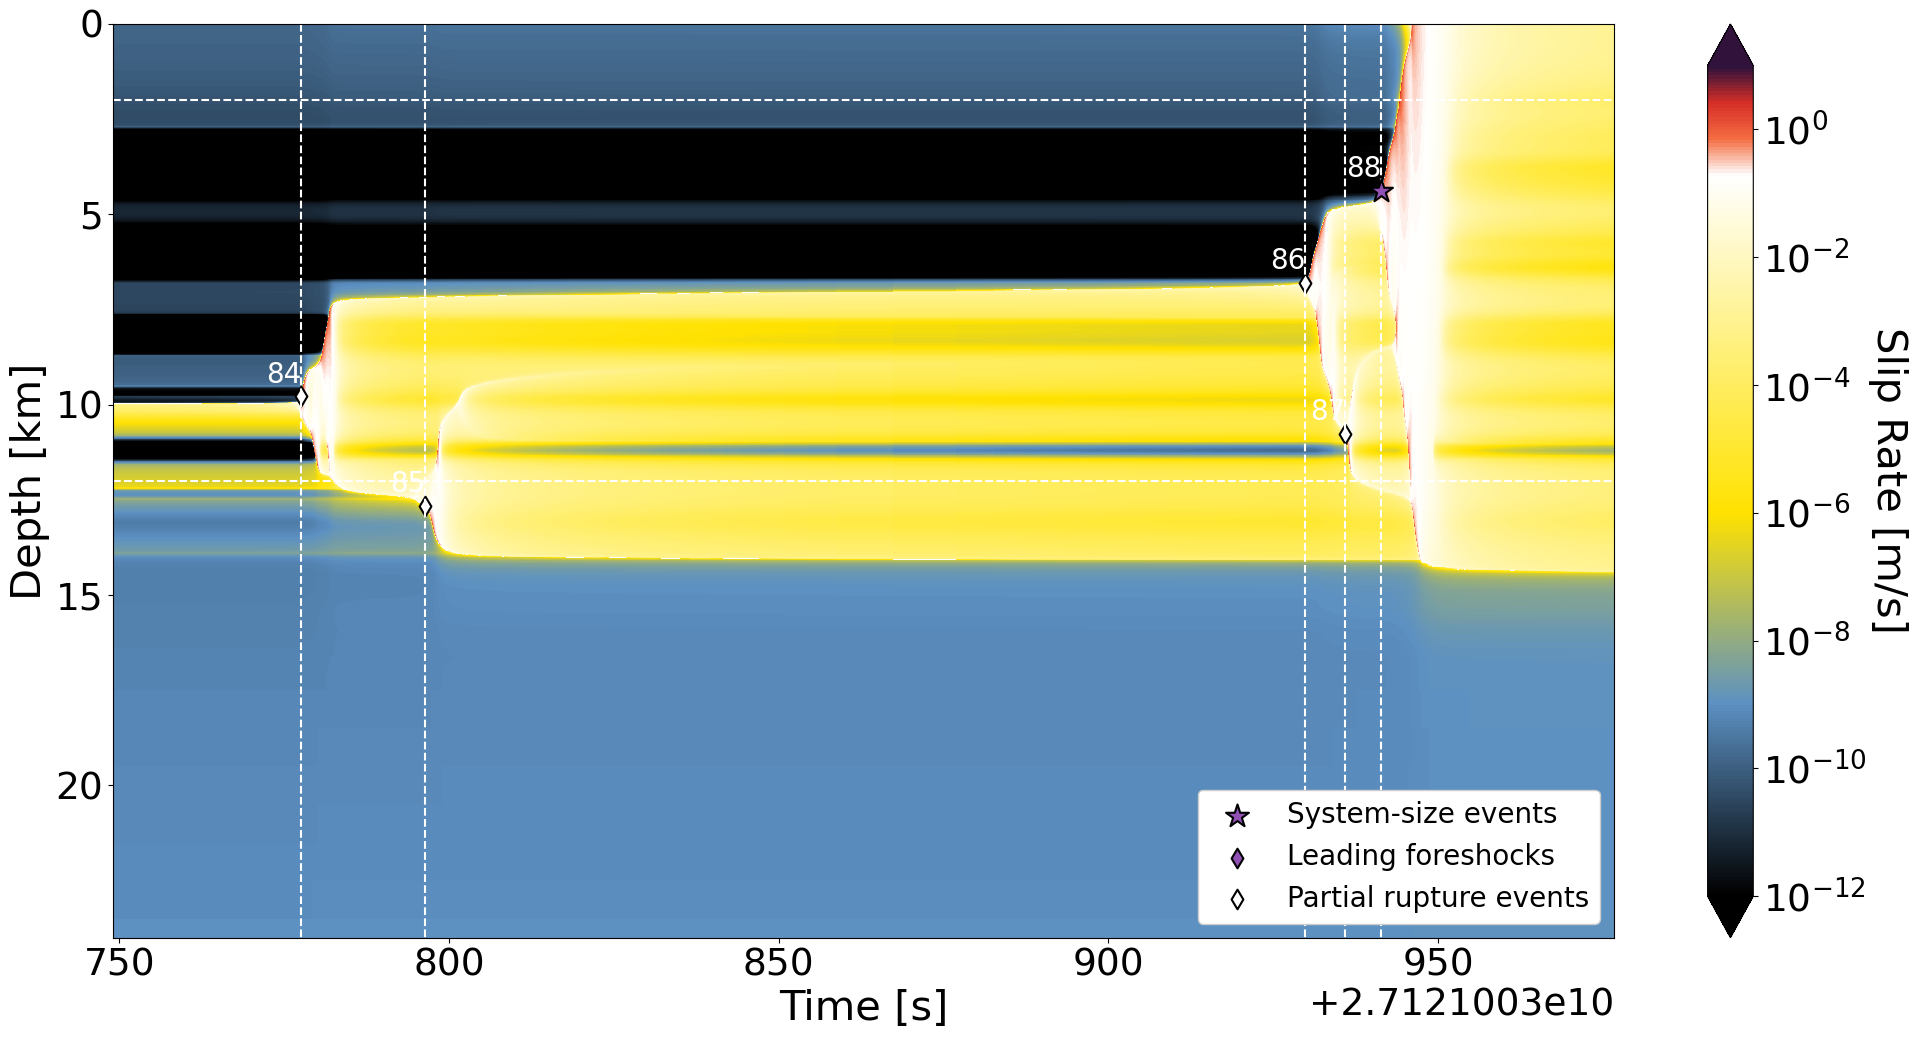

In [11]:
save_on = 1
ax = fout_image(image,outputs,dep,params,cumslip_outputs,save_dir,prefix,rths,vmin,vmax,Vths,zoom_frame,plot_in_timestep=False,plot_in_sec=True,cb_off=False,publish=publish,save_on=save_on)

## Image plot with peak

In [ ]:
save_on = 0
ax = fout_image(image,outputs,dep,params,cumslip_outputs,save_dir,prefix,rths,vmin,vmax,Vths,zoom_frame,plot_in_timestep=False,plot_in_sec=True,cb_off=False,save_on=save_on)

ax2 = ax.twinx()
if image == 'sliprate':
    var = np.log10(np.max(sr[:,its-buffer1:ite+buffer2],axis=0))
    ylab = r'$\log_{10}$(Peak Slip Rate [m/s])'
    # hy = -2
    hy = np.log10(Vths)
    ytick_inc = 4
    yl = [-6,18]
elif image == 'shearT':
    var = abs(shearT[:,its-buffer1:ite+buffer2])
    var = np.array([var[i,:]-shearT[i,0] for i in range(var.shape[0])])
    var = np.max(var,axis=0)
    ylab = 'Peak Shear Stress Change [MPa])'
    hy = []
    ytick_inc = 10
    # yl = [30,100]
    yl = [-5,65]
t = time[0][its-buffer1:ite+buffer2]
ax2.plot(t,var,'k',lw=2.5)
ax2.hlines(y=hy,xmin=t.min(),xmax=t.max(),color=mp.myburgundy,linestyles='--',lw=2)
ax2.hlines(y=hy*0.9,xmin=t.min(),xmax=t.max(),color=mp.mypink,linestyles='--',lw=2)
ax2.hlines(y=hy*1.1,xmin=t.min(),xmax=t.max(),color=mp.mypalepink,linestyles='--',lw=2)
ax2.set_ylabel(ylab,fontsize=30,rotation=270,labelpad=30)
ax2.set_yticks(np.arange(yl[0],yl[1]+ytick_inc,ytick_inc))
ax2.set_ylim(yl)

plt.tight_layout()
if save_on:
    plt.savefig('%s/withPEAK_zoom_%s_image_ev%dto%dd.png'%(save_dir,image,iev1,iev2),dpi=300)


# Appendix: Vths from Barbot (2019)

In [ ]:
# Vbarbot = 2*Vs*(b-a)*sigma_n/mu
mu = params.item().get('mu')
rho = params.item().get('rho0')
Vs = np.sqrt(mu/rho)
print(Vs)

mesh_y,_a,_b,_ab,_sigma,_Dc = ch.make_uniform(prefix)
VW = np.where(_ab<0)[0]
aa = _a[VW]; bb = _b[VW]; mesh_y = mesh_y[VW]; sigma_n = _sigma[VW]; D_c = _Dc[VW]

Vbarbot = 2*Vs*(bb-aa)*sigma_n/mu
# print(np.log10(Vbarbot))
print(np.log10(np.mean(Vbarbot)))
print(np.log10(Vbarbot).min())
print(np.log10(Vbarbot).max())

# plt.rcParams['font.size'] = '15'
# fig,ax = plt.subplots(figsize=(3.5,7))

# ax.plot(Vbarbot,-mesh_y,color='k',lw=3,label='a/b',zorder=3)
# print('Vbarbot = %2.3f - %2.3f m/s'%(min(Vbarbot),max(Vbarbot)))
# ax.set_xlabel('Vbarbot [m/s]',fontsize=17)
# ax.set_ylabel('Depth [km]',fontsize=17)
# ax.set_xscale('log')
# xl = ax.get_xlim()
# # ax.set_xlim(0,xl[1])
# # ax.set_xlim(0,500)
# ax.set_ylim(0,24)
# ax.invert_yaxis()
# ax.grid(True)
# if max(D_c)-min(D_c) > 1e-4:
#     ax.text(xl[0]*2,23,'Mu = %dGPa\nDc: fractal\nMin. %2.2e m/s\nMax. %2.2e m/s'%(mu,min(Vbarbot),max(Vbarbot)),fontsize=16,va='bottom',ha='left',bbox=mp.tboxprop)
# else:
#     ax.text(xl[0]*2,23,'Mu = %dGPa\nDc = %2.2f mm\nMin. %2.2e m/s\nMax. %2.2e m/s'%(mu,min(D_c*1e3),min(Vbarbot),max(Vbarbot)),fontsize=16,va='bottom',ha='left',bbox=mp.tboxprop)

# plt.tight_layout()
# plt.show()

# Appendix2: average stress tau_av (Beall et al., 2019)

In [ ]:
save_on = 0
spatial_mean = np.mean(shearT,axis=0)
tyrs = time[0]/sc.yr2sec
ii = np.where(tyrs>=200)[0][0]
tau_av = np.max(spatial_mean[ii:])
itau_av = np.argmax(spatial_mean[ii:])
ver_info = ch.version_info(prefix)

plt.rcParams['font.size'] = '15'
plt.figure(figsize=(10,6))
plt.plot(tyrs[0:ii],spatial_mean[0:ii],color='0.8',lw=2)
plt.plot(tyrs[ii:],spatial_mean[ii:],color='k',lw=2)
plt.hlines(y=tau_av,xmin=tyrs[ii],xmax=tyrs[-1],linestyles='--',lw=2,color=mp.myburgundy)
plt.text(tyrs[itau_av],tau_av,r'$\mathbf{\tau_{av}}$ = %2.2f'%(tau_av),ha='left',va='bottom',fontsize=17,fontweight='bold',color=mp.myburgundy)
plt.title(ver_info,fontsize=20,fontweight='bold')
plt.xlabel('Time [yrs]',fontsize=17)
plt.ylabel('Spatial Average of Shear Stress [MPa]',fontsize=17)
plt.tight_layout()
if save_on:
    plt.savefig('%s/tau_av.png'%(save_dir),dpi=300)
plt.show()

# Appendix3: Generate short outputs to save time

In [ ]:
print(outputs.shape[1])
save_on = 1
inc = 4.5e5
c = 0
while c + inc <= outputs.shape[1]:
    if c + 2*inc <= outputs.shape[1]:
        short_outputs = outputs[:,int(c):int(c+inc),:]
        print(int(c),':',int(c+inc),';',short_outputs.shape[1])
    else:
        short_outputs = outputs[:,int(c):,:]
        print(int(c),':',';',short_outputs.shape[1])
    if save_on:
        print('Save in %s/short_outputs_%d'%(save_dir,c/inc))
        np.save('%s/short_outputs_%d'%(save_dir,c/inc),short_outputs)
    else:
        print('%s/short_outputs_%d'%(save_dir,c/inc))
    c += inc